In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
import math
torch.set_default_dtype(torch.float64) # set arithmetic to be double precision

In [2]:
def ExactSolution(x,y):
    # y^{2} * sin(pi*x)
    return y**2 * torch.sin(math.pi * x)

In [3]:
def prepare_data(xmin,xmax,nx,ymin,ymax,ny,strip_bdry):
    x1 = torch.linspace(xmin,xmax,steps = nx)
    y1 = torch.linspace(ymin,ymax,steps = ny)
    if strip_bdry == True:
        grid_x, grid_y = torch.meshgrid(x1[1:nx-1],y1[1:ny-1],indexing = 'ij')
    else:
        grid_x, grid_y = torch.meshgrid(x1,y1,indexing = 'ij')
    xcol = torch.reshape(grid_x,(grid_x.numel(),1))
    ycol = torch.reshape(grid_y,(grid_y.numel(),1))
    data_matrix = torch.cat((xcol,ycol),1)
    return grid_x, grid_y, data_matrix

tensor([[0.1250, 0.1250],
        [0.1250, 0.2500],
        [0.1250, 0.3750],
        [0.1250, 0.5000],
        [0.1250, 0.6250],
        [0.1250, 0.7500],
        [0.1250, 0.8750],
        [0.2500, 0.1250],
        [0.2500, 0.2500],
        [0.2500, 0.3750],
        [0.2500, 0.5000],
        [0.2500, 0.6250],
        [0.2500, 0.7500],
        [0.2500, 0.8750],
        [0.3750, 0.1250],
        [0.3750, 0.2500],
        [0.3750, 0.3750],
        [0.3750, 0.5000],
        [0.3750, 0.6250],
        [0.3750, 0.7500],
        [0.3750, 0.8750],
        [0.5000, 0.1250],
        [0.5000, 0.2500],
        [0.5000, 0.3750],
        [0.5000, 0.5000],
        [0.5000, 0.6250],
        [0.5000, 0.7500],
        [0.5000, 0.8750],
        [0.6250, 0.1250],
        [0.6250, 0.2500],
        [0.6250, 0.3750],
        [0.6250, 0.5000],
        [0.6250, 0.6250],
        [0.6250, 0.7500],
        [0.6250, 0.8750],
        [0.7500, 0.1250],
        [0.7500, 0.2500],
        [0.7500, 0.3750],
        [0.7

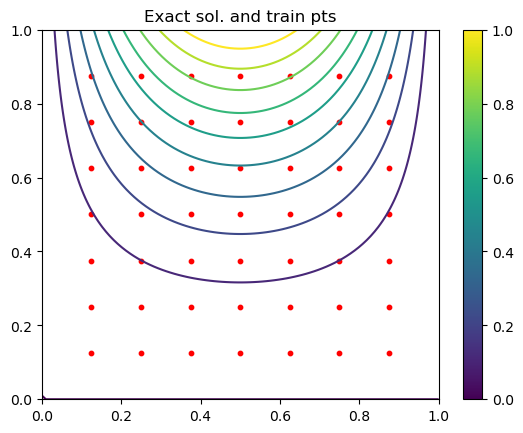

In [4]:
# define training points
npt1 = 9
strip_boundary = True
xtrain_grid, ytrain_grid, train_data = prepare_data(0.,1.,npt1,0.,1.,npt1,strip_boundary)

# define test points
npt2 = 100
strip_boundary = False
xtest_grid, ytest_grid, xytest = prepare_data(0.,1.,npt2,0.,1.,npt2,strip_boundary)

# find the exact solution at the test points
sol_exact = ExactSolution(xtest_grid,ytest_grid)
sol_exact_vector = torch.reshape(sol_exact,(torch.numel(sol_exact),1))
sol_min = torch.min(sol_exact_vector)
sol_max = torch.max(sol_exact_vector)

# plot the exact solution and the training points
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_exact,torch.arange(sol_min,sol_max,(sol_max-sol_min)*0.1))  
plt.scatter(train_data[:,0],train_data[:,1],s = 10, c = '#FF0000')
plt.colorbar()
plt.title("Exact sol. and train pts")

train_data.requires_grad_(True)

In [5]:
class NN(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # 1st hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size,out_size)
        
    def forward(self, xb):
#         act = nn.Tanh()
#         act = torch.sigmoid()
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = torch.tanh(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def N1(self, xb):
#         act = nn.Tanh()
#         act = torch.sigmoid()
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = torch.tanh(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def Ny1(self, xb):
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = 1 / torch.cosh(out).pow(2)
        # Multiply by the weight associated with y (assuming xb = [x, y])
        out *= self.linear1.weight[:, 1]
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def Nx(self, xb):
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = 1 / torch.cosh(out).pow(2)
        # Multiply by the weight associated with x (assuming xb = [x, y])
        out *= self.linear1.weight[:, 0]
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def Nxx(self, xb):
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = -2*torch.sinh(out)/torch.cosh(out).pow(3)
        # Multiply by the weight associated with x (assuming xb = [x, y])
        out *= self.linear1.weight[:, 0]
        out *= self.linear1.weight[:, 0]
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def Nxy(self, xb):
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = -2*torch.sinh(out)/torch.cosh(out).pow(3)
        # Multiply by the weight associated with x and y (assuming xb = [x, y])
        out *= self.linear1.weight[:, 0]
        out *= self.linear1.weight[:, 1]
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def Nxxy(self, xb):
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = (4*torch.sinh(out).pow(2)-2)/torch.cosh(out).pow(4)
        # Multiply by the weight associated with x and y (assuming xb = [x, y])
        out *= self.linear1.weight[:, 0]
        out *= self.linear1.weight[:, 0]
        out *= self.linear1.weight[:, 1]
        # Get predictions using output layer
        out = self.linear2(out)
        return out

In [6]:
def SolutionModel(x,y,NN,N1,Ny1):
    # u(x,y) = B(x,y) + x(1-x)y[NN(x,y;w) - NN(x,1;w) - (d/dy)*NN(x,1;w)], where
    # B(x,y) = y[2sin(pi*x)]
    B = 2*y*(torch.sin(math.pi*x)) 
    mul = x*(1-x)*y
    sol = B[:,None] + mul[:,None]*(NN - N1 - Ny1)
    
    return sol

def Solution(x,y,NN,N1,Ny1):
    # u(x,y) = B(x,y) + x(1-x)y[NN(x,y;w) - NN(x,1;w) - (d/dy)*NN(x,1;w)], where
    # B(x,y) = y[2sin(pi*x)]
    B = 2*y*(torch.sin(math.pi*x)) 
    mul = x*(1-x)*y
    sol = B + mul*(NN - N1 - Ny1)
    
    return sol

def RHS(x,y):
    return (2 - math.pi**2 * y**2) * torch.sin(math.pi * x)


In [7]:
N_neuron = 10
input_size = 2
output_size = 1

model = NN(input_size,N_neuron,output_size)

In [8]:
print(model.linear1.weight.shape)
print(model.linear1.weight)
print(model.linear1.bias)
print(model.linear1.bias.shape)
print(model.linear2.weight.shape)

torch.Size([10, 2])
Parameter containing:
tensor([[ 0.5453,  0.3356],
        [ 0.0220,  0.6322],
        [-0.3572, -0.5212],
        [-0.0750,  0.1820],
        [ 0.3277,  0.1467],
        [-0.3341, -0.2868],
        [ 0.7025, -0.6276],
        [ 0.4911, -0.6247],
        [ 0.3252, -0.0659],
        [-0.4768,  0.0772]], requires_grad=True)
Parameter containing:
tensor([ 0.3416, -0.2595,  0.1318, -0.0305,  0.2593,  0.7010,  0.1307, -0.4703,
        -0.3151, -0.2440], requires_grad=True)
torch.Size([10])
torch.Size([1, 10])


In [9]:
#prepare training data
size1,size2 = train_data.shape
rhs = torch.zeros(size1,)
train_ds = TensorDataset(train_data,rhs)

batch_size = 256
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [10]:
for epoch in range(4000):
    TOL = 1.0e-6
    for X,y in train_dl:
        optimizer.zero_grad()
        
        # NN(x,y;w)
        nn_approx = model(X)
    
        result_tensor = torch.cat((X[:,0].unsqueeze(1), torch.ones_like(X[:,0]).unsqueeze(1)), dim=1)
        # NN(x,1;w)
        n1 = model.N1(result_tensor)
        # NNy(x,1;w)
        ny1 = model.Ny1(result_tensor)
        
        Q = SolutionModel(X[:,0],X[:,1],nn_approx,n1,ny1)
        
        derivQ = torch.autograd.grad(Q,X,allow_unused=True, retain_graph=True, grad_outputs = torch.ones_like(Q), create_graph=True)
        dQ = derivQ[0]
        
        deriv_xx_xy = torch.autograd.grad(dQ[:,0], X,allow_unused=True,grad_outputs=torch.ones_like(dQ[:,0]), \
        retain_graph=True, create_graph=True)
        
        deriv_yx_yy = torch.autograd.grad(dQ[:,1], X,allow_unused=True,grad_outputs=torch.ones_like(dQ[:,1]), \
        retain_graph=True, create_graph=True)
        
#         nx = model.Nx(X)
#         nx1 = model.Nx(result_tensor)
#         nxx = model.Nxx(X)
#         nxx1 = model.Nxx(result_tensor)
#         nxy = model.Nxy(X)
#         nxy1 = model.Nxy(result_tensor)
#         nxxy1 = model.Nxxy(result_tensor)
        
#         xt = X[:,0].unsqueeze(1)
#         yt = X[:,1].unsqueeze(1)
#         uxx = (-2*(math.pi**2)*yt*torch.sin(math.pi*xt)) + (-2)*yt*(nn_approx-n1-ny1) + yt*(1-2*xt)*(nx-nx1-nxy1) + yt*(1-2*xt)*(nx-nx1-nxy1) + yt*(xt-xt**2)*(nxx-nxx1-nxxy1)
#         uyy = 2*math.pi*yt*torch.cos(math.pi*xt) + yt*(1-2*xt)*(nn_approx-n1-ny1) + yt*(xt-xt**2)*(nx-nx1-nxy1)

#         lhs = uxx+uyy - RHS(X[:,0],X[:,1])

        Qyy = deriv_yx_yy[0][:,1]
        Qxx = deriv_xx_xy[0][:,0]
        
        lhs = Qxx+Qyy - RHS(X[:,0],X[:,1])
    
        loss = loss_fn(lhs,y)
        loss.backward()
        optimizer.step()

    if epoch % 100 == 1:
        print('loss at epoch {} is {}'.format(epoch,loss))
    if loss < TOL:
        break

loss at epoch 1 is 45.12086589816463
loss at epoch 101 is 0.16311279502808076
loss at epoch 201 is 0.08491572013284468
loss at epoch 301 is 0.048396525392808955
loss at epoch 401 is 0.030889701852351528
loss at epoch 501 is 0.020736679507381974
loss at epoch 601 is 0.013863642524524523
loss at epoch 701 is 0.009354698768769053
loss at epoch 801 is 0.006555423332425534
loss at epoch 901 is 0.004525922557456733
loss at epoch 1001 is 0.0033460739093465856
loss at epoch 1101 is 0.002742839697004429
loss at epoch 1201 is 0.0023729590942043713
loss at epoch 1301 is 0.0021106305530150977
loss at epoch 1401 is 0.0019086912373573333
loss at epoch 1501 is 0.0017428399966021974
loss at epoch 1601 is 0.0015986849640042303
loss at epoch 1701 is 0.001467468975865812
loss at epoch 1801 is 0.00134383918748485
loss at epoch 1901 is 0.0012246207027668736
loss at epoch 2001 is 0.0011082134300593443
loss at epoch 2101 is 0.0009943253940438925
loss at epoch 2201 is 0.0008838240606544923
loss at epoch 2301 

Max error =  0.05698662347016825
Mean error =  0.010924713415784723
RMS error =  0.016369409774086737


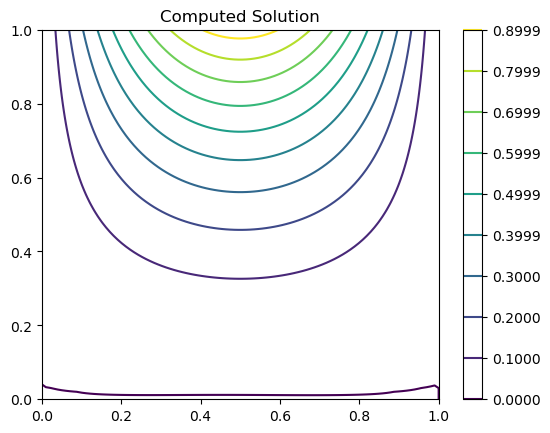

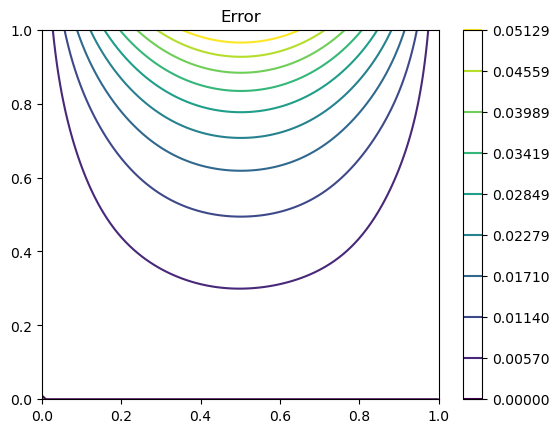

In [11]:
sol_test = torch.zeros(npt2,npt2)
Ntest = torch.numel(sol_test)
for i in range(npt2):
    for j in range(npt2):
        pt = torch.tensor([[xtest_grid[i,j],ytest_grid[i,j]]])
        # NN(x,y;w)
        nn_approx = model(pt)
        # NN(x,1;w)
        result_tensor = torch.cat((pt[:,0].unsqueeze(1), torch.ones_like(pt[:,0]).unsqueeze(1)), dim=1)
        n1 = model.N1(result_tensor)
        # NNy(x,1;w)
        ny1 = model.Ny1(result_tensor)
        sol_test[i,j] = Solution(xtest_grid[i,j],ytest_grid[i,j],nn_approx,n1,ny1)
        
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_test.detach().numpy(),torch.arange(sol_min,sol_max,0.1*(sol_max-sol_min)))   
plt.colorbar()
plt.title("Computed Solution")
# compare with the exact solution
error = torch.abs(sol_test - sol_exact).detach().numpy()
error_vector = np.reshape(error,(Ntest,1))
error_max = np.max(error_vector)
plt.figure()
plt.contour(xtest_grid,ytest_grid,error,np.arange(0.,error_max,error_max*0.1))  
plt.colorbar()
plt.title("Error")
print("Max error = ",np.max(error_vector))
print("Mean error = ",np.mean(error_vector))
print("RMS error = ",np.sqrt(np.mean(error_vector**2)))